# Evaluation metrics for classifcation

## 4.1 Evaluation metrics: session overview

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [9]:
len(y_val)

1409

In [10]:
(y_val == churn_decision).sum()

1132

In [11]:
(y_val == churn_decision).mean()

0.8034066713981547

In [12]:
1132/1409

0.8034066713981547

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [15]:
thresholds = np.linspace(0, 1, 21)
print(thresholds)

scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
#     score = (y_val == churn_decision).mean()
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.738
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


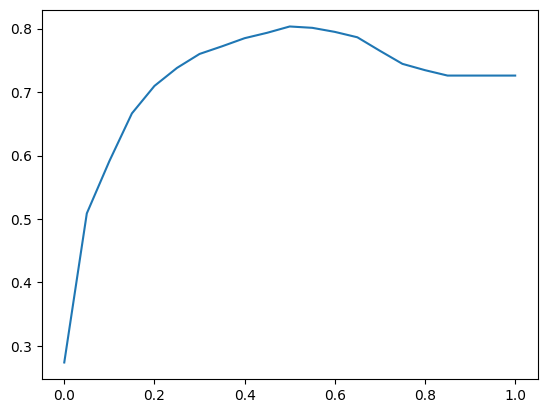

In [16]:
plt.plot(thresholds, scores)

In [17]:
from collections import Counter

In [18]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

- Our model: 80%
- Dummy model (return false only): 73%

In [19]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [20]:
y_val.mean()

0.2739531582682754

In [21]:
1 - y_val.mean()

0.7260468417317246

## Confusion table
- Different types of errors and correct decisions
- Arranging them in a table

In [22]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [23]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [24]:
predict_positive.mean()

0.2207239176721079

In [25]:
(predict_positive & actual_positive).sum()

210

In [26]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [27]:
tp, tn, fp, fn

(210, 922, 101, 176)

In [28]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [29]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 4.4 Precision and recall
- Precision: Fraction of positive predictions that are correct
- Recall: Fraction of correctly identified positive examples

In [30]:
p = tp / (tp + fp)
p

0.6752411575562701

In [31]:
r = tp / (tp + fn)
r

0.5440414507772021

## 4.5 ROC curves
- Receiver operative characteristics curve

### TPR and FPR

In [32]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [33]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [34]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [35]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,1,110,0.997409,0.892473
2,0.02,384,830,2,193,0.994819,0.811339
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


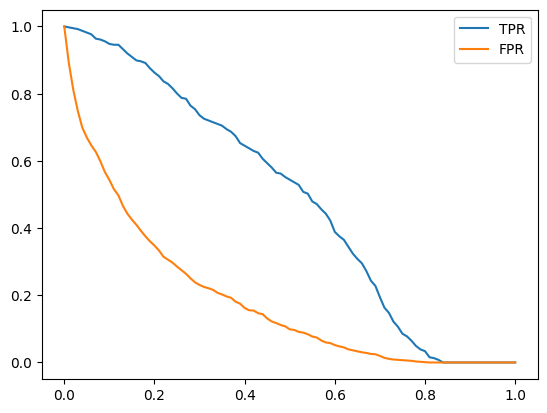

In [36]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [37]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [38]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [59]:
type((predict_negative & actual_negative))

numpy.ndarray

In [39]:
 def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [40]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

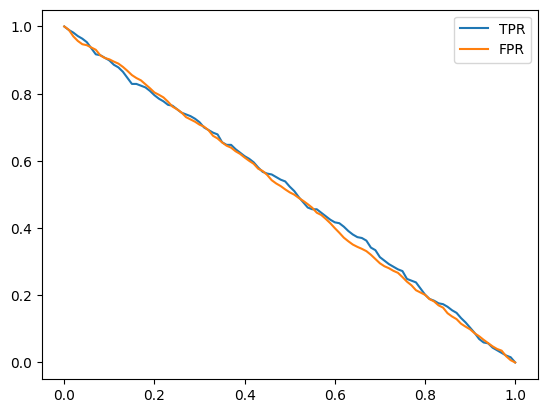

In [41]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal model

In [42]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [43]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [44]:
y_ideal_pred = np.linspace(0, 1, len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [45]:
1 - y_val.mean()

0.7260468417317246

In [46]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [47]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


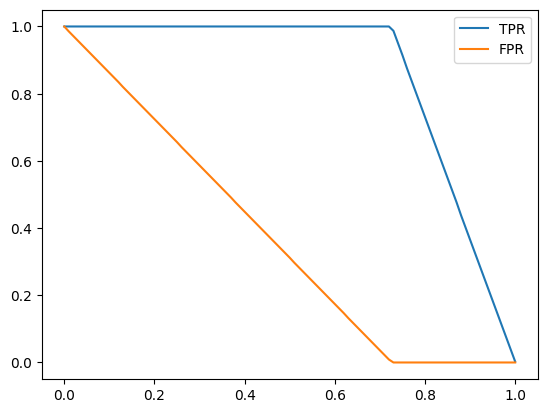

In [48]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

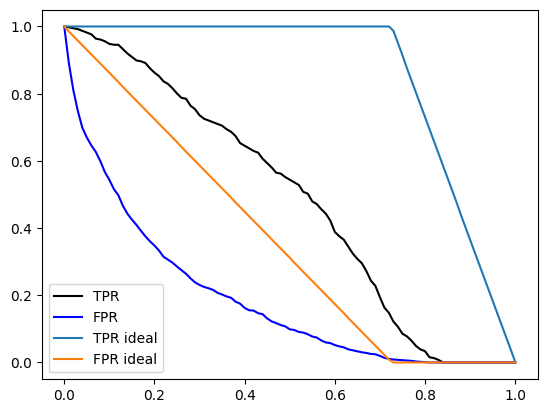

In [49]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

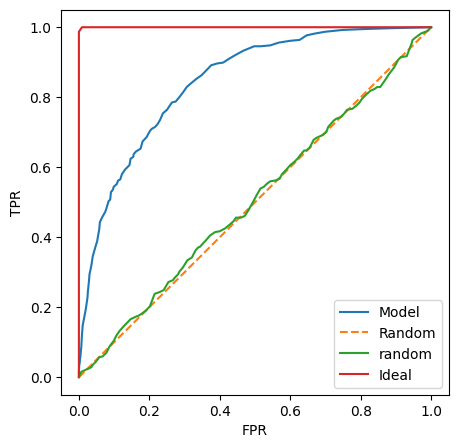

In [50]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')
plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [51]:
from sklearn.metrics import roc_curve

In [52]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

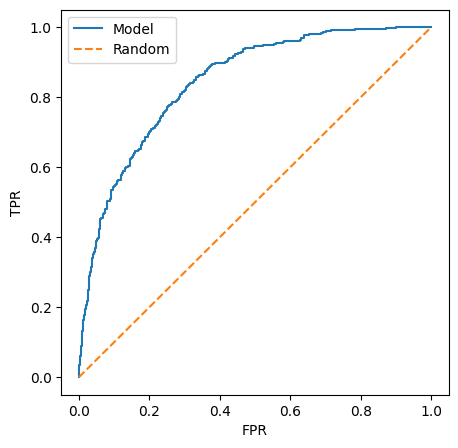

In [53]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 4.6 ROC AUC
- Area under the ROC curve -useful metric
- Interpretation of AUC
  - Probability that a randomly selected positive example has a greater score than a randomly selected negative example.

In [56]:
from sklearn.metrics import auc

In [57]:
auc(fpr, tpr)

0.8438505057258191

In [60]:
auc(df_scores.fpr, df_scores.tpr)

0.8437732666798354

In [61]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [62]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438505057258191

In [63]:
from sklearn.metrics import roc_auc_score

In [64]:
roc_auc_score(y_val, y_pred)

0.8438505057258191

In [65]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [67]:
import random

In [68]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.845

In [71]:
pos_ind = np.random.randint(0, len(pos) - 1, size=n)
neg_ind = np.random.randint(0, len(neg) - 1, size=n)

(pos[pos_ind] > neg[neg_ind]).mean()


0.84256

## 4.7 Cross validation
- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [72]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [73]:
dv, model = train(df_train, y_train)

In [74]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [76]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.00898402, 0.20465385, 0.21237973, ..., 0.13629567, 0.79978596,
       0.83744071])

In [77]:
from sklearn.model_selection import KFold

In [79]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
kfold

KFold(n_splits=10, random_state=1, shuffle=True)

In [81]:
kfold.split(df_full_train)

<generator object _BaseKFold.split at 0x7f91a07414a0>

In [82]:
next(kfold.split(df_full_train))

(array([   0,    1,    2, ..., 5631, 5632, 5633]),
 array([   4,   21,   28,   33,   44,   58,   67,   72,   79,   81,   82,
          98,  101,  116,  119,  125,  126,  136,  141,  147,  161,  169,
         179,  192,  196,  200,  206,  214,  222,  231,  250,  255,  259,
         276,  280,  285,  301,  308,  313,  314,  325,  343,  354,  359,
         383,  386,  407,  420,  428,  433,  440,  447,  457,  473,  486,
         496,  501,  503,  507,  545,  554,  557,  566,  574,  580,  582,
         592,  605,  608,  623,  634,  636,  645,  662,  667,  684,  687,
         689,  729,  745,  758,  763,  778,  783,  792,  795,  808,  839,
         840,  847,  850,  858,  867,  870,  871,  881,  899,  906,  927,
         929,  931,  940,  943,  976,  984,  987,  988, 1005, 1016, 1028,
        1034, 1038, 1050, 1056, 1074, 1079, 1117, 1122, 1123, 1131, 1134,
        1139, 1144, 1155, 1159, 1163, 1169, 1179, 1198, 1206, 1216, 1238,
        1247, 1256, 1272, 1297, 1298, 1310, 1344, 1356, 1370,

In [83]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [84]:
len(train_idx), len(val_idx)

(5070, 564)

In [85]:
len(df_full_train)

5634

In [87]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [89]:
!pip install tqdm

You should consider upgrading via the '/home/pinku/miniconda3/bin/python -m pip install --upgrade pip' command.


In [90]:
from tqdm.auto import tqdm

In [91]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.007
C=0.5 0.840 +- 0.006
C=1 0.841 +- 0.008
C=5 0.841 +- 0.007
C=10 0.841 +- 0.007

